In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
import rdflib
from lxml import etree
import pandas
import re
import xml.etree.ElementTree as ET
import os

# c) General
import copy
import difflib
import numpy as np

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams

In [2]:
# Ontologies:
# Save the .csv files of each ontology from https://bioportal.bioontology.org/ontologies
FMA = pandas.read_csv('FMA.csv')
CHEBI = pandas.read_csv('CHEBI.csv')
OPB = pandas.read_csv('OPB.csv')
GO = pandas.read_csv('GO.csv')

# Extraction of IDs & Labels in the ontologies

fmaID = FMA['Class ID']
fmaLabel= FMA['Preferred Label']
chebiID = CHEBI['Class ID']
chebiLabel= CHEBI['Preferred Label']
opbID = OPB['Class ID']
opbLabel= OPB['Preferred Label']
goID = GO['Class ID']
goLabel= GO['Preferred Label']

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (41,71,75,77,99,100,103,113,114,138,140,156,157,158,178,198) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11,12,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [4]:
## Insert the addresses in the same order for both the CellML files and the connectivity matrices
categories=[['egfr'],['m'],['m'],['m'],['m'],['m']];
addresses=['/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/CellML files/EGFR_pathway.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/CellML files/MAPK_L1.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/CellML files/MAPK_L2.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/CellML files/MAPK_L3.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/CellML files/MAPK_L4.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/CellML files/MAPK_L5.cellml']
connectivityMatricesLocation=[
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/Connectivity Matrices/connectivityMatrixEGFR.csv',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/Connectivity Matrices/connectivityMatrixMapk.csv',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/Connectivity Matrices/connectivityMatrixMapk.csv',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/Connectivity Matrices/connectivityMatrixMapk.csv',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/Connectivity Matrices/connectivityMatrixMapk.csv',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK_EGF/Connectivity Matrices/connectivityMatrixMapk.csv']

In [5]:
## Asking for the .csv file containing the connectivity matrix of the system
# Input(s): connectivityMatrix: The .csv file ( ex. 'connectivityMatrix.csv' )

# Output(s): CMlist: The connectivity matrix which is converted into a list.

def csvToList(connectivityMatricesLocation):
    CMlist={}
    for i in range(len(connectivityMatricesLocation)):
        
        cm = pandas.read_csv(connectivityMatricesLocation[i])
        CM=cm.to_numpy()
        CMlist[i]=[]
        
        for j in range(len(CM)):
            List=list(CM[j])
            del List[0]
            CMlist[i].append(List)
    return CMlist
    

In [6]:
CMlist = csvToList(connectivityMatricesLocation)

In [7]:
## Extracting the data (annotations & values) from the CellML files

#  Input(s):    add: The list of locations (addresses) which is the output from the "catRecognition" function

#  Output(s):   a) List: a dictionary containing the names of the variables in the CellML files (in the order of the 
#                        found annotations)
#               b) annotations: a dictionary containing the annotations in the CellML files
#               c) root: a dictionary containing the imported XML data from the CellML files

def getAnnotations(add):
    parser = etree.XMLParser(recover=True)
    root = etree.parse(add, parser).getroot()
    rdfGraph = rdflib.Graph()
    for rdfElement in root.iter():
        if rdfElement.tag.endswith('RDF'):
            try:
                rdfGraph.parse(data = etree.tostring(rdfElement))
            except:
                pass
            
    def getLeaves(sbj, graph):
        triples = list(graph.triples((sbj,None,None)))
        leaves = []
        if len(triples)>0:
            for s, p, o in triples:
                result =  getLeaves(o,graph)
                leaves += result
            return list(set(leaves))
        else:
            return [sbj]
        
    # Opens the CellML file and returns the list of variables names
#     base=os.path.basename(add)
    f = open(add,'r')
    text = f.read()
    root = ET.fromstring(text)

    rdfs = root.findall('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF')

    List1=[]
    for child in rdfs:
        for grand in child:
            List1.append(grand.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'))
    
    List = list(dict.fromkeys(List1))
    List.remove('#metaid0')


    triplesList={}
    for i in range(len(List)):
        sbj = rdflib.URIRef(List[i])
        triplesList[i]=getLeaves(sbj, rdfGraph)

        # In this part we match the number found in the rdf of the CellML file 
        # with the ones found in the "Class IDs" and "Preferred Labels"

    annotations1={}

    for i in range(len(triplesList)):
        annotations1[i]=[]
        for k in range(len(triplesList[i])):
            l=triplesList[i][k]
            if 'opb' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for OPB
                for j in range(len(opbID)):
                    numID=re.findall(r'\d+', opbID[j])
                    if numCell == numID:
                        annotations1[i].append(opbLabel[j])
            elif 'chebi' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for CHEBI
                for j in range(len(chebiID)):
                    numID=re.findall(r'\d+', chebiID[j])
                    if numCell == numID:
                        annotations1[i].append(chebiLabel[j])
            elif 'fma' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for FMA
                for j in range(len(fmaID)):
                    numID=re.findall(r'\d+', fmaID[j])
                    if numCell == numID:
                        annotations1[i].append(fmaLabel[j])

            elif 'go' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for GO
                for j in range(len(goID)):
                    numID=re.findall(r'\d+', goID[j])
                    if numCell == numID:
                        annotations1[i].append(goLabel[j])

            else: # Reaction names are free-style descriptions!
                annotations1[i].append(l.lower()) # So we look for it separately.


    for i in range(len(annotations1)):
        annotations1[i]=[x.lower() for x in annotations1[i]] 

    annotations = {}; k=0;

    for key,value in annotations1.items():
        if value not in annotations.values():
            annotations[k] = value
            k+=1

    return [List,annotations,root]

In [8]:
## Extracting values from the CellML files

#  Input(s):  root: a dictionary containing the imported XML data from the output of the "getAnnotations" functions

#  Output(s): els: (representing the elements) a dictionary containing the names of the variables in the CellML files 
#                  (in the order of the  found initial amounts)
#             init: (representing the initials) a dictionary containing the initial amounts of the variables in the 
#                   CellML files 

def valExtraction(root): 
    
    variables=[]; els=[]; init=[];

    components = root.findall('{http://www.cellml.org/cellml/1.1#}component')


    for comp in components:
        variables.append(comp.findall('{http://www.cellml.org/cellml/1.1#}variable'))


    for var in variables:
        for v in var:   #Here search for the variable names(els) and their initial amounts(init)
            els.append(v.attrib['{http://www.cellml.org/metadata/1.0#}id'])   

            if 'initial_value' in v.attrib: # if any initial value exists take it
                init.append(v.attrib['initial_value'])    
            else:
                init.append(None)
    return[els,init]

In [9]:
model=bgt.new(name='EGFR+MAPK')

In [15]:
referenceAnnots={'egfr':{ 0: ['temperature'], # T
                          1: ['ideal gas constant'], # ideal gas constant     
                          2: ['concentration of chemical', 'ras protein signal transduction'], # Ras
                          3: ['concentration of chemical', 'epidermal growth factor receptor binding','cytosol'], #Rai
                          4: ['transcription ternary complex', 'concentration of chemical'], # R_G_S
                          5: ['shc-grb2-sos complex', 'concentration of chemical'],
                          6: ['concentration of chemical', 'granzyme b production'],
                          7: ['concentration of chemical', 'sevenless binding'],
                          8: ['concentration of chemical', 'phospholipase binding'],
                          9: ['concentration of chemical','g protein-coupled receptor kinase activity'],
                          10:['concentration of chemical', 'grb2-shp-2 complex'],
                          11:['concentration of chemical', 'grb2-egfr complex'],
                          12:['receptor complex', 'concentration of chemical'],
                          13:['egfr-shc-grb2-sos complex', 'concentration of chemical'],
                          14:['concentration of chemical', 'shc-egfr complex'],
                          15:['concentration of chemical', 'protein kinase binding'],
                          16:['concentration of chemical', 'ribosomal large subunit binding'],
                          17:['concentration of chemical', 'protein autophosphorylation'],
                          18:['concentration of chemical', 'grb2-shc complex'],
                          19:['shc-egfr complex','concentration of chemical','phosphoprotein binding'],
                          20:['concentration of chemical', 'phospholipase c activity'],
                          21:['concentration of chemical','protein kinase binding','phosphoprotein binding'],
                          22:['concentration of chemical', 'epidermal growth factor binding'],
                          23:['concentration of chemical', 'phospholipase inhibitor activity'],
                          24:['concentration of chemical','ribosomal large subunit binding','phosphoprotein binding'],
                          25:['concentration of chemical','epidermal growth factor receptor binding','extracellular region'],
                          26:['concentration of chemical','activation of transmembrane receptor protein tyrosine kinase activity'],

                         27: ['thermodynamical rate property', 'ras protein signal transduction'], # K_Ras
                         28: ['cytosol','thermodynamical rate property','epidermal growth factor receptor binding'],
                         29: ['transcription ternary complex', 'thermodynamical rate property'],
                         30: ['shc-grb2-sos complex', 'thermodynamical rate property'],
                         31: ['thermodynamical rate property', 'granzyme b production'],
                         32: ['sevenless binding', 'thermodynamical rate property'],
                         33: ['thermodynamical rate property', 'phospholipase binding'],
                         34: ['g protein-coupled receptor kinase activity','thermodynamical rate property'],
                         35: ['thermodynamical rate property', 'grb2-shp-2 complex'],
                         36: ['thermodynamical rate property', 'grb2-egfr complex'],
                         37: ['receptor complex', 'thermodynamical rate property'],
                         38: ['egfr-shc-grb2-sos complex', 'thermodynamical rate property'],
                         39: ['shc-egfr complex', 'thermodynamical rate property'],
                         40: ['protein kinase binding', 'thermodynamical rate property'],
                         41: ['thermodynamical rate property', 'ribosomal large subunit binding'],
                         42: ['protein autophosphorylation', 'thermodynamical rate property'],
                         43: ['thermodynamical rate property', 'grb2-shc complex'],
                         44: ['shc-egfr complex','thermodynamical rate property','phosphoprotein binding'],
                         45: ['phospholipase c activity', 'thermodynamical rate property'],
                         46: ['protein kinase binding','thermodynamical rate property','phosphoprotein binding'],
                         47: ['thermodynamical rate property', 'epidermal growth factor binding'],
                         48: ['thermodynamical rate property', 'phospholipase inhibitor activity'],
                         49: ['ribosomal large subunit binding','thermodynamical rate property','phosphoprotein binding'],
                         50: ['epidermal growth factor receptor binding','thermodynamical rate property','extracellular region'],
                         51: ['thermodynamical rate property','activation of transmembrane receptor protein tyrosine kinase activity'],
                         
                         
                          52: ['re1', 'reaction rate constant'],
                          53: ['re2', 'reaction rate constant'],
                          54: ['re3', 'reaction rate constant'],
                          55: ['re4', 'reaction rate constant'],
                          56: ['re5', 'reaction rate constant'],
                          57: ['re6', 'reaction rate constant'],
                          58: ['re7', 'reaction rate constant'],
                          59: ['re8', 'reaction rate constant'],
                          60: ['re9', 'reaction rate constant'],
                          61: ['re10', 'reaction rate constant'],
                          62: ['re11', 'reaction rate constant'], 
                          63: ['re12', 'reaction rate constant'],
                          64: ['re13', 'reaction rate constant'],
                          65: ['re14', 'reaction rate constant'],
                          66: ['re15', 'reaction rate constant'], 
                          67: ['re16', 'reaction rate constant'], 
                          68: ['re17', 'reaction rate constant'],
                          69: ['re18', 'reaction rate constant'],
                          70: ['re19', 'reaction rate constant'],
                          71: ['re20', 'reaction rate constant'],
                          72: ['reaction rate constant', 're21'],
                          73: ['reaction rate constant', 're22'],
                          74: ['re23', 'reaction rate constant'],
                          75: ['re24', 'reaction rate constant'], 
                          76: ['re25', 'reaction rate constant'],
                          77: ['re26', 'reaction rate constant']},
'mapk_1':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase kinase activity'],  # MKKK
            6: ['concentration of chemical', 'activation of mapkkk activity'], # MKKKP
            7: ['concentration of chemical', 'ras protein signal transduction'],  # E1=MKKKK (Ras)                                
            8: ['map kinase phosphatase activity', 'concentration of chemical'], # E2=MKKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['thermodynamical rate property', 'atp binding'], #K_ATP
            12: ['thermodynamical rate property', 'adp binding'], #K_ADP
            13: ['thermodynamical rate property', 'phosphate ion binding'], # K_P
            14: ['thermodynamical rate property', 'map kinase kinase kinase activity'],  # K_MKKK
            15: ['thermodynamical rate property', 'activation of mapkkk activity'], # K_MKKKP
            16: ['thermodynamical rate property', 'ras protein signal transduction'], # K_MKKKK      
            17: ['thermodynamical rate property','map kinase phosphatase activity'], # K_MKKK_Pase
            18: ['thermodynamical rate property','protein phosphorylation'], # K_C1
            19: ['thermodynamical rate property','protein dephosphorylation'], # K_C2
            20: ['reaction rate constant','map kinase kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','activation of mapkkk activity', 'phosphate ion binding','reaction rate constant']}, # r4  


'mapk_2':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase activity'],  # MKK
            6: ['concentration of chemical', 'activation of mapkk activity'], # MKKP
            7: ['concentration of chemical', 'activation of mapkkk activity'], # E1=MKKKP
            8: ['concentration of chemical', 'phosphatase binding'], # E2=MKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase kinase activity'],  # K_MKK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapkk activity'], # K_MKKP
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_E1=K_MKKKP
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase activity'], #K_E2
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['thermodynamic constant','concentration of chemical','protein dephosphorylation'], # K_C2
            20: ['reaction rate constant','map kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','map kinase kinase activity', 'phosphate ion binding','reaction rate constant']}, # r4

'mapk_3':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'activation of mapkk activity'],  # MKKP
            6: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # MKKPP
            7: ['concentration of chemical', 'activation of mapkkk activity'],  # E1=MKKKP                    
            8: ['concentration of chemical', 'phosphatase binding'], # E2=MKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'activation of mapkk activity'],  # K_MKKP
            15: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # K_MKKPP
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_MKKKP (E1)
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase binding'], # K_MKKPase (E2)
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['phosphorylation','protein phosphorylation','reaction rate constant','atp binding','activation of mapkkk activity'], # r1                      
            21: ['phosphorylation','protein phosphorylation','reaction rate constant','adp binding','mitogen-activated protein kinase kinase binding'],# r2
            22: ['mitogen-activated protein kinase kinase binding','dephosphorylation','protein dephosphorylation','reaction rate constant'], #r3 
            23: ['phosphate ion binding','dephosphorylation','protein dephosphorylation','reaction rate constant','activation of mapkk activity']}, # r4

'mapk_4':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P                
            5:  ['concentration of chemical', 'map kinase activity'], # MK
            6: ['concentration of chemical', 'activation of mapk activity'], # MKP
            7: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'],# E1=MKKPP
            8: ['concentration of chemical', 'phosphatase complex'],  # E2=MK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase activity'], # K_MK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapk activity'],  # K_MKP
            16: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # K_MKKPP
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase complex'], # K_MK_Pase
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['phosphorylation','protein phosphorylation','reaction rate constant','atp binding', 'mitogen-activated protein kinase kinase binding'], # r1
            21: ['adp binding','phosphorylation','protein phosphorylation','reaction rate constant', 'activation of mapk activity'], # r2
            22: ['activation of mapk activity','dephosphorylation','protein dephosphorylation','reaction rate constant'], #r3 
            23: ['dephosphorylation','protein dephosphorylation','reaction rate constant','phosphate ion binding','map kinase activity']},# r4

'mapk_5':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P 
            5: ['concentration of chemical', 'activation of mapk activity'], # MKP
            6: ['concentration of chemical', 'mitogen-activated protein kinase binding'], # MKPP
            7: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'], #E1=MKKPP   
            8: ['concentration of chemical',  'phosphatase complex'],  # E2=MK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'activation of mapk activity'], # MKP
            15: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase binding'], # MKPP               
            16: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], #K_E1(MKKPP)   
            17: ['thermodynamic constant','concentration of chemical',  'phosphatase complex'],  # K_E2(MK_Pase)               
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['phosphorylation','reaction rate constant','atp binding','mitogen-activated protein kinase kinase binding'], #r1               
            21: ['phosphorylation','reaction rate constant','adp binding','mitogen-activated protein kinase kinase binding'], #r2               
            22: ['reaction rate constant','dephosphorylation','protein dephosphorylation','mitogen-activated protein kinase binding'], #r3               
            23: ['reaction rate constant','dephosphorylation','phosphate ion binding','activation of mapk activity']}}

In [17]:
## BG Symbolic Models

# def symbolicModelGenerator():  
    
listMAPK={}; annotationsMAPKunsorted={}; rootMAPK={}; elementsMAPK={}; initialsMAPK={}; 

listEGF={}; annotationsEGFunsorted={}; rootEGF={}; elementsEGF={}; initialsEGF={}; 

def egfrModelMaker(referenceAnnots,annotations): 
    

    RR={}; EGF={}; Rae={}; Rai={}; R2={}; RP={}; R_PL={}; R_PLP={}; PLC_gamma={}; PLC_gamma_P={}; PLC_gammaPI={};
    Grb={}; R_G={}; G_S={}; R_GS={}; SOS={}; R_Sh={}; Shc={}; R_ShP={}; ShP={}; R_ShG={}; Sh_G={}; R_ShGS={}; 
    ShGS={}; Ras={}; Re1={}; Re2={}; Re3={}; Re4={}; Re5={}; Re6={}; Re7={}; Re8={}; Re9={}; Re10={}; Re11={}; Re12={}; 
    Re13={}; Re14={}; Re15={}; Re16={}; Re17={}; Re21={}; Re18={}; Re19={}; Re20={}; Re22={}; Re23={}; Re24={}; 
    Re25={}; Re26={}; zeroJunc_R={}; zeroJunc_EGF={}; zeroJunc_Rae={}; zeroJunc_Rai={}; zeroJunc_R2={}; zeroJunc_RP={}; 
    zeroJunc_R_PL={}; zeroJunc_R_PLP={}; zeroJunc_PLC_gamma={}; zeroJunc_PLC_gamma_P={}; zeroJunc_PLC_gammaPI={}; 
    zeroJunc_R_G={}; zeroJunc_Grb={}; zeroJunc_R_GS={}; zeroJunc_SOS={}; zeroJunc_G_S={}; zeroJunc_R_Sh={}; 
    zeroJunc_ShP={}; zeroJunc_R_ShG={}; zeroJunc_Sh_G={}; zeroJunc_R_ShGS={}; zeroJunc_ShGS={}; zeroJunc_Ras={}; 
    zeroJunc_Shc={}; zeroJunc_R_ShP={}; oneJunc_1_reac={}; oneJunc_1_prod={}; oneJunc_2_reac={}; 
    oneJunc_2_prod={}; oneJunc_3_reac={}; oneJunc_3_prod={}; oneJunc_4_reac={}; oneJunc_4_prod={}; oneJunc_5_reac={}; oneJunc_5_prod={}; oneJunc_6_reac={}; 
    oneJunc_6_prod={};oneJunc_7_reac={}; oneJunc_7_prod={}; oneJunc_8_reac={}; oneJunc_8_prod={}; oneJunc_9_reac={}; 
    oneJunc_9_prod={}; oneJunc_10_reac={}; oneJunc_10_prod={}; oneJunc_11_reac={}; oneJunc_11_prod={}; 
    oneJunc_12_reac={}; oneJunc_12_prod={}; oneJunc_13_reac={}; oneJunc_13_prod={}; oneJunc_14_reac={}; 
    oneJunc_14_prod={}; oneJunc_15_reac={}; oneJunc_15_prod={}; oneJunc_16_reac={}; oneJunc_16_prod={}; 
    oneJunc_17_reac={}; oneJunc_17_prod={}; oneJunc_18_reac={}; oneJunc_18_prod={}; oneJunc_21_reac={}; 
    oneJunc_21_prod={}; oneJunc_19_reac={}; oneJunc_19_prod={}; oneJunc_20_reac={}; oneJunc_20_prod={}; 
    oneJunc_22_reac={}; oneJunc_22_prod={}; oneJunc_24_reac={}; oneJunc_24_prod={}; 
    oneJunc_23_reac={}; oneJunc_23_prod={}; oneJunc_25_reac={}; oneJunc_25_prod={}; oneJunc_26_reac={};
    oneJunc_26_prod={};  

    Type={};
    for a in range(len(annotations)):
        EGF_found=0; SOS_found=0; Grb_found=0; R_ShGS_found=0; 
        for aa in range(len(annotations[str(a)])): 
            if 'epidermal growth factor binding' in annotations[str(a)][aa]:# EGF
                EGF_found+=1
            elif 'sevenless binding' in annotations[str(a)][aa]: # SOS
                SOS_found+=1
            elif 'granzyme b production' in annotations[str(a)][aa]: # Grb
                Grb_found+=1
            elif 'egfr-shc-grb2-sos complex' in annotations[str(a)][aa]: # R_ShGS
                R_ShGS_found+=1
        if EGF_found != 0 and SOS_found != 0 and Grb_found != 0 and R_ShGS_found != 0: # It's the EGFR pathway to Ras
            Type[str(a)]=[]
            Type[str(a)].append(list(referenceAnnots.keys()).index('egfr')); # The index of the file which is the EGFR pathway

    newAnnot={}
    for key,value,Typek,Typev in zip(annotations.keys(),annotations.values(),Type.keys(),Type.values()):
        if key==Typek: 
            newAnnot[str(Typev[0])]=copy.deepcopy(value)

    for a in newAnnot.keys(): 
        Ras[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][2]), library="BioChem")
        Rai[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][3]), library="BioChem")
        R_GS[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][4]), library="BioChem")
        ShGS[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][5]), library="BioChem")
        Grb[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][6]), library="BioChem")
        SOS[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][7]), library="BioChem")
        PLC_gamma_P[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][8]), library="BioChem")
        G_S[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][9]), library="BioChem")
        R_ShG[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][10]), library="BioChem")
        R_G[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][11]), library="BioChem")
        RR[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][12]), library="BioChem")
        R_ShGS[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][13]), library="BioChem")
        R_Sh[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][14]), library="BioChem")
        Shc[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][15]), library="BioChem")
        R_PL[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][16]), library="BioChem")
        R2[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][17]), library="BioChem")
        Sh_G[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][18]), library="BioChem")
        R_ShP[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][19]), library="BioChem")
        PLC_gamma[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][20]), library="BioChem")
        ShP[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][21]), library="BioChem")
        EGF[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][22]), library="BioChem")
        PLC_gammaPI[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][23]), library="BioChem")
        R_PLP[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][24]), library="BioChem")
        Rae[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][25]), library="BioChem")
        RP[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][26]), library="BioChem")

        # Reactions
        Re1[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][52]) , library="BioChem")
        Re2[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][53]) , library="BioChem")
        Re3[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][54]) , library="BioChem")
        Re4[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][55]) , library="BioChem")
        Re5[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][56]) , library="BioChem")
        Re6[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][57]) , library="BioChem")
        Re7[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][58]) , library="BioChem")
        Re8[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][59]) , library="BioChem")
        Re9[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][60]) , library="BioChem")
        Re10[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][61]) , library="BioChem")
        Re11[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][62]) , library="BioChem")
        Re12[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][63]) , library="BioChem")
        Re13[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][64]) , library="BioChem")
        Re14[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][65]) , library="BioChem")
        Re15[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][66]) , library="BioChem")
        Re16[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][67]) , library="BioChem")
        Re17[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][68]) , library="BioChem")
        Re18[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][69]) , library="BioChem")
        Re19[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][70]) , library="BioChem")
        Re20[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][71]) , library="BioChem")
        Re21[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][72]) , library="BioChem")
        Re22[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][73]) , library="BioChem")
        Re23[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][74]) , library="BioChem")
        Re24[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][75]) , library="BioChem")
        Re25[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][76]) , library="BioChem")
        Re26[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][77]) , library="BioChem")

        # Junctions
        zeroJunc_Ras[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][2]))
        zeroJunc_Rai[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][3]))
        zeroJunc_R_GS[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][4]))
        zeroJunc_ShGS[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][5]))
        zeroJunc_Grb[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][6]))
        zeroJunc_SOS[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][7]))
        zeroJunc_PLC_gamma_P[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][8]))
        zeroJunc_G_S[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][9]))
        zeroJunc_R_ShG[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][10]))
        zeroJunc_R_G[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][11]))
        zeroJunc_R[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][12]))
        zeroJunc_R_ShGS[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][13]))
        zeroJunc_R_Sh[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][14]))
        zeroJunc_Shc[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][15]))
        zeroJunc_R_PL[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][16]))
        zeroJunc_R2[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][17]))
        zeroJunc_Sh_G[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][18]))
        zeroJunc_R_ShP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][19]))
        zeroJunc_PLC_gamma[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][20]))
        zeroJunc_ShP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][21]))
        zeroJunc_EGF[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][22]))
        zeroJunc_PLC_gammaPI[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][23]))
        zeroJunc_R_PLP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][24]))
        zeroJunc_Rae[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][25]))
        zeroJunc_RP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][26]))

        oneJunc_1_reac[int(a)] = bgt.new("1");  oneJunc_1_prod[int(a)] = bgt.new("1");        
        oneJunc_2_reac[int(a)] = bgt.new("1");  oneJunc_2_prod[int(a)] = bgt.new("1");        
        oneJunc_3_reac[int(a)] = bgt.new("1");  oneJunc_3_prod[int(a)] = bgt.new("1");        
        oneJunc_4_reac[int(a)] = bgt.new("1");  oneJunc_4_prod[int(a)] = bgt.new("1");        
        oneJunc_5_reac[int(a)] = bgt.new("1");  oneJunc_5_prod[int(a)] = bgt.new("1");        
        oneJunc_6_reac[int(a)] = bgt.new("1");  oneJunc_6_prod[int(a)] = bgt.new("1");        
        oneJunc_7_reac[int(a)] = bgt.new("1");  oneJunc_7_prod[int(a)] = bgt.new("1");        
        oneJunc_8_reac[int(a)] = bgt.new("1");  oneJunc_8_prod[int(a)] = bgt.new("1");       
        oneJunc_9_reac[int(a)] = bgt.new("1");  oneJunc_9_prod[int(a)] = bgt.new("1");
        oneJunc_10_reac[int(a)] = bgt.new("1"); oneJunc_10_prod[int(a)] = bgt.new("1");
        oneJunc_11_reac[int(a)] = bgt.new("1"); oneJunc_11_prod[int(a)] = bgt.new("1");
        oneJunc_12_reac[int(a)] = bgt.new("1"); oneJunc_12_prod[int(a)] = bgt.new("1");
        oneJunc_13_reac[int(a)] = bgt.new("1"); oneJunc_13_prod[int(a)] = bgt.new("1");
        oneJunc_14_reac[int(a)] = bgt.new("1"); oneJunc_14_prod[int(a)] = bgt.new("1");
        oneJunc_15_reac[int(a)] = bgt.new("1"); oneJunc_15_prod[int(a)] = bgt.new("1");
        oneJunc_16_reac[int(a)] = bgt.new("1"); oneJunc_16_prod[int(a)] = bgt.new("1");
        oneJunc_17_reac[int(a)] = bgt.new("1"); oneJunc_17_prod[int(a)] = bgt.new("1");
        oneJunc_18_reac[int(a)] = bgt.new("1"); oneJunc_18_prod[int(a)] = bgt.new("1");
        oneJunc_19_reac[int(a)] = bgt.new("1"); oneJunc_19_prod[int(a)] = bgt.new("1");
        oneJunc_20_reac[int(a)] = bgt.new("1"); oneJunc_20_prod[int(a)] = bgt.new("1");
        oneJunc_21_reac[int(a)] = bgt.new("1"); oneJunc_21_prod[int(a)] = bgt.new("1");
        oneJunc_22_reac[int(a)] = bgt.new("1"); oneJunc_22_prod[int(a)] = bgt.new("1");
        oneJunc_23_reac[int(a)] = bgt.new("1"); oneJunc_23_prod[int(a)] = bgt.new("1");
        oneJunc_24_reac[int(a)] = bgt.new("1"); oneJunc_24_prod[int(a)] = bgt.new("1");
        oneJunc_25_reac[int(a)] = bgt.new("1"); oneJunc_25_prod[int(a)] = bgt.new("1");
        oneJunc_26_reac[int(a)] = bgt.new("1"); oneJunc_26_prod[int(a)] = bgt.new("1");

    # Dictionary containing the generated BG components ("Components")
    Components={}; mergeableComponents={}
    for a in newAnnot.keys(): 

        Components[a]={0:RR[int(a)], 1:EGF[int(a)], 2:Rae[int(a)], 3:Rai[int(a)], 4:R2[int(a)], 5:RP[int(a)], 
                       6:R_PL[int(a)], 7:R_PLP[int(a)], 8:PLC_gamma[int(a)], 9:PLC_gamma_P[int(a)], 
                       10:PLC_gammaPI[int(a)], 11:Grb[int(a)], 12:Shc[int(a)], 13:SOS[int(a)], 14:ShGS[int(a)], 
                       15:Sh_G[int(a)], 16:ShP[int(a)], 17:G_S[int(a)], 18:R_ShGS[int(a)],
                       19:R_ShG[int(a)], 20:R_ShP[int(a)], 21:R_Sh[int(a)], 22:R_GS[int(a)], 
                       23:R_G[int(a)], 24:Re1[int(a)],
                       25:Re2[int(a)], 26:Re3[int(a)], 27:Re4[int(a)], 28:Re5[int(a)], 29:Re6[int(a)], 
                       30:Re7[int(a)], 31:Re8[int(a)], 32:Re9[int(a)], 33:Re10[int(a)], 34:Re11[int(a)], 
                       35:Re12[int(a)], 36:Re13[int(a)], 37:Re14[int(a)], 38:Re15[int(a)], 39:Re16[int(a)], 
                       40:Re17[int(a)], 41:Re18[int(a)], 42:Re19[int(a)], 43:Re20[int(a)], 44:Re21[int(a)], 
                       45:Re22[int(a)], 46:Re23[int(a)], 47:Re24[int(a)], 48:Re25[int(a)], 49:zeroJunc_R[int(a)],
                       50:zeroJunc_EGF[int(a)], 51:zeroJunc_Rae[int(a)], 52:zeroJunc_Rai[int(a)], 
                       53:zeroJunc_R2[int(a)], 54:zeroJunc_RP[int(a)], 55:zeroJunc_R_PL[int(a)], 
                       56:zeroJunc_R_PLP[int(a)], 57:zeroJunc_PLC_gamma[int(a)], 58:zeroJunc_PLC_gamma_P[int(a)],
                       59:zeroJunc_PLC_gammaPI[int(a)], 60:zeroJunc_Grb[int(a)], 61:zeroJunc_Shc[int(a)],
                       62:zeroJunc_SOS[int(a)], 63:zeroJunc_ShGS[int(a)], 64:zeroJunc_Sh_G[int(a)],
                       65:zeroJunc_ShP[int(a)], 66:zeroJunc_G_S[int(a)], 67:zeroJunc_R_ShGS[int(a)], 
                       68:zeroJunc_R_ShG[int(a)], 69:zeroJunc_R_ShP[int(a)], 70:zeroJunc_R_Sh[int(a)],
                       71:zeroJunc_R_GS[int(a)], 72:zeroJunc_R_G[int(a)], 73:oneJunc_1_reac[int(a)], 
                       74:oneJunc_1_prod[int(a)],
                       75:oneJunc_2_reac[int(a)], 76:oneJunc_2_prod[int(a)], 77:oneJunc_3_reac[int(a)],
                       78:oneJunc_3_prod[int(a)], 79:oneJunc_4_reac[int(a)], 80:oneJunc_4_prod[int(a)],
                       81:oneJunc_5_reac[int(a)], 82:oneJunc_5_prod[int(a)], 83:oneJunc_6_reac[int(a)],
                       84:oneJunc_6_prod[int(a)], 85:oneJunc_7_reac[int(a)], 86:oneJunc_7_prod[int(a)],
                       87:oneJunc_8_reac[int(a)], 88:oneJunc_8_prod[int(a)], 89:oneJunc_9_reac[int(a)], 
                       90:oneJunc_9_prod[int(a)], 91:oneJunc_10_reac[int(a)], 92:oneJunc_10_prod[int(a)],
                       93:oneJunc_11_reac[int(a)], 94:oneJunc_11_prod[int(a)], 95:oneJunc_12_reac[int(a)],
                       96:oneJunc_12_prod[int(a)], 97:oneJunc_13_reac[int(a)], 98:oneJunc_13_prod[int(a)],
                       99:oneJunc_14_reac[int(a)], 100:oneJunc_14_prod[int(a)], 101:oneJunc_15_reac[int(a)],
                       102:oneJunc_15_prod[int(a)], 103:oneJunc_16_reac[int(a)], 104:oneJunc_16_prod[int(a)],
                       105:oneJunc_17_reac[int(a)], 106:oneJunc_17_prod[int(a)], 107:oneJunc_18_reac[int(a)],
                       108:oneJunc_18_prod[int(a)], 109:oneJunc_19_reac[int(a)], 110:oneJunc_19_prod[int(a)],
                       111:oneJunc_20_reac[int(a)], 112:oneJunc_20_prod[int(a)], 113:oneJunc_21_reac[int(a)],
                       114:oneJunc_21_prod[int(a)], 115:oneJunc_22_reac[int(a)], 116:oneJunc_22_prod[int(a)],
                       117:oneJunc_23_reac[int(a)], 118:oneJunc_23_prod[int(a)], 119:oneJunc_24_reac[int(a)], 
                       120:oneJunc_24_prod[int(a)], 121:oneJunc_25_reac[int(a)], 122:oneJunc_25_prod[int(a)],
                       123:oneJunc_26_reac[int(a)], 124:Ras[int(a)], 125:zeroJunc_Ras[int(a)], 
                       126:Re26[int(a)], 127:oneJunc_26_prod[int(a)]}


    # List of mergeable components along with their corresponding junctions for later merging ("mergeableComponents")
        mergeableComponents[a]={RR[int(a)], EGF[int(a)], zeroJunc_R[int(a)], 
                                zeroJunc_EGF[int(a)], Ras[int(a)], zeroJunc_Ras[int(a)]}
    return [mergeableComponents,Components,newAnnot]


def mapkModelMaker(referenceAnnots,annotations): 

    # Counting the number of unique entities in each loop to detect the loop
    # Based on a number of specific entities, the number of the loop in the MAPK cascade is determined

    E1={}; E2={}; C1={}; C2={}; M={}; MP={}; ATP={}; ADP={}; P={}; Re1={}; Re2={}; Re3={}; Re4={}; zeroJunctionE1={};
    zeroJunctionE2={}; zeroJunctionC1={}; zeroJunctionC2={}; zeroJunctionM={}; zeroJunctionMP={}; zeroJunctionATP={};
    zeroJunctionADP={}; zeroJunctionP={}; oneJunctionReactantsRe1={}; oneJunctionProductsRe2={}; oneJunctionReactantsRe3={}; 
    oneJunctionProductsRe4={}; 

    # Finding the loop which each input file corresponds to:
    Loop={}
    for a in annotations.keys():
        MKKKK_found=0; MKKK_found=0; MKKKP_found=0; MKPP_found=0; 
        MKK_found=0; MKKp_found=0; MKKPase_found=0; MKKPP_found=0; MK_found=0; MKP_found=0;
        for aa in annotations[str(a)]: 
            if 'ras protein signal transduction' in annotations[str(a)][aa]:# MKKKK
                MKKKK_found+=1
            elif 'map kinase kinase kinase activity' in annotations[str(a)][aa]: # MKKK
                MKKK_found+=1
            elif 'activation of mapkkk activity' in annotations[str(a)][aa]: # MKKKP
                MKKKP_found+=1
            elif 'map kinase kinase activity' in annotations[str(a)][aa]: # MKK
                MKK_found+=1
            elif 'activation of mapkk activity' in annotations[str(a)][aa]: # MKKP
                MKKp_found+=1    
            elif 'phosphatase binding' in annotations[str(a)][aa]: # MKK_Pase
                MKKPase_found+=1 
            elif 'mitogen-activated protein kinase kinase binding' in annotations[str(a)][aa]: # MKKPP
                MKKPP_found+=1
            elif 'map kinase activity' in annotations[str(a)][aa]: # MK
                MK_found+=1
            elif 'activation of mapk activity' in annotations[str(a)][aa]: # MKP
                MKP_found+=1
            elif 'mitogen-activated protein kinase binding' in annotations[str(a)][aa]: # MKPP
                MKPP_found+=1

        if MKKKK_found != 0 and MKKK_found != 0 : # It's the first loop in the cascade
            Loop[str(a)]=[]
            Loop[str(a)].append(list(referenceAnnots.keys()).index('mapk_1')); # The index of the file that is the first loop
        elif MKK_found != 0 :
            Loop[str(a)]=[]
            Loop[str(a)].append(list(referenceAnnots.keys()).index('mapk_2')); # The index of the file that is the second loop
        elif MKKp_found != 0 and MKKPase_found != 0 and MKKPP_found !=0:
            Loop[str(a)]=[]
            Loop[str(a)].append(list(referenceAnnots.keys()).index('mapk_3')); # The index of the file that is the third loop
        elif MK_found != 0 :
            Loop[str(a)]=[]
            Loop[str(a)].append(list(referenceAnnots.keys()).index('mapk_4')); # The index of the file that is the fourth loop
        elif MKPP_found != 0 and MKKPP_found != 0 and MKP_found !=0:
            Loop[str(a)]=[]
            Loop[str(a)].append(list(referenceAnnots.keys()).index('mapk_5')); # The index of the file that is the fifth loop


    newAnnot={}
    for key,value,loopk,loopv in zip(annotations.keys(),annotations.values(),Loop.keys(),Loop.values()):
        if key==loopk: 
            newAnnot[str(loopv[0])]=copy.deepcopy(value)




    for a in newAnnot.keys():        
        E1[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][7]), library="BioChem")  
        E2[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][8]), library="BioChem")  
        C1[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][9]), library="BioChem")
        C2[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][10]), library="BioChem")
        M[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][5]), library="BioChem")   
        MP[int(a)] = bgt.new("Ce", name=set(list(referenceAnnots.values())[int(a)][6]), library="BioChem")  
        ATP[int(a)] = bgt.new("Ce_S", name=set(list(referenceAnnots.values())[int(a)][2]), library="BioChem")
        ADP[int(a)] = bgt.new("Ce_S", name=set(list(referenceAnnots.values())[int(a)][3]), library="BioChem")
        P[int(a)] = bgt.new("Ce_S", name=set(list(referenceAnnots.values())[int(a)][4]), library="BioChem")

        # Reactions
        Re1[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][20]) , library="BioChem")
        Re2[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][21]) , library="BioChem")
        Re3[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][22]) , library="BioChem")
        Re4[int(a)] = bgt.new("Re" , name=set(list(referenceAnnots.values())[int(a)][23]) , library="BioChem")

        # Junctions
        zeroJunctionE1[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][7]))
        zeroJunctionE2[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][8]))
        zeroJunctionC1[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][9]))
        zeroJunctionC2[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][10]))
        zeroJunctionM[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][5]))
        zeroJunctionMP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][6]))
        zeroJunctionATP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][2]))
        zeroJunctionADP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][3]))
        zeroJunctionP[int(a)] = bgt.new("0", name=set(list(referenceAnnots.values())[int(a)][4]))
        oneJunctionReactantsRe1[int(a)] = bgt.new("1", name=set(list(referenceAnnots.values())[int(a)][20]))
        oneJunctionProductsRe2[int(a)] = bgt.new("1", name=set(list(referenceAnnots.values())[int(a)][21]))
        oneJunctionReactantsRe3[int(a)] = bgt.new("1", name=set(list(referenceAnnots.values())[int(a)][22]))
        oneJunctionProductsRe4[int(a)] = bgt.new("1", name=set(list(referenceAnnots.values())[int(a)][23]))




    # Dictionary containing the generated BG components ("Components")
    Components={}; mergeableComponents={}
    for a in newAnnot.keys(): 

        Components[a]={0:E1[int(a)], 1:E2[int(a)], 2:C1[int(a)], 3:C2[int(a)], 4:M[int(a)], 5:MP[int(a)], 
                  6:ATP[int(a)], 7:ADP[int(a)], 8:P[int(a)], 9:Re1[int(a)], 10:Re2[int(a)], 11:Re3[int(a)],
                  12:Re4[int(a)],13:zeroJunctionE1[int(a)],14:zeroJunctionE2[int(a)],15:zeroJunctionC1[int(a)],
                  16:zeroJunctionC2[int(a)],17:zeroJunctionM[int(a)],18:zeroJunctionMP[int(a)],19:zeroJunctionATP[int(a)],
                  20:zeroJunctionADP[int(a)], 21:zeroJunctionP[int(a)],22:oneJunctionReactantsRe1[int(a)],
                  23:oneJunctionProductsRe2[int(a)], 24:oneJunctionReactantsRe3[int(a)], 25:oneJunctionProductsRe4[int(a)]} 

        # List of mergeable components along with their corresponding junctions for later merging ("mergeableComponents")
        #For now, C1 & C2 are not considered among mergeable components despite having the same annotations!
        #Maybe later will be added ....
        mergeableComponents[a]={E1[int(a)], E2[int(a)], M[int(a)], MP[int(a)], ATP[int(a)], ADP[int(a)], P[int(a)],
                                zeroJunctionE1[int(a)],zeroJunctionE2[int(a)], zeroJunctionM[int(a)],zeroJunctionMP[int(a)], 
                                zeroJunctionATP[int(a)], zeroJunctionADP[int(a)],zeroJunctionP[int(a)]}  



    return [mergeableComponents,Components,newAnnot]


for i in range(len(categories)):

    if categories[i][0] == 'egfr':

        [listEGF[str(i)],annotationsEGFunsorted[str(i)],rootEGF[str(i)]]=getAnnotations(addresses[i])        
        [elementsEGF[str(i)],initialsEGF[str(i)]]=valExtraction(rootEGF[str(i)])

        [mergeableComponentsEGFR,ComponentsEGFR,annotationsEGF]=egfrModelMaker(referenceAnnots,annotationsEGFunsorted)


    elif categories[i][0] == 'm':

        [listMAPK[str(i)],annotationsMAPKunsorted[str(i)],rootMAPK[str(i)]]=getAnnotations(addresses[i])        
        [elementsMAPK[str(i)],initialsMAPK[str(i)]]=valExtraction(rootMAPK[str(i)])

        [mergeableComponentsMAPK,ComponentsMAPK,annotationsMAPK]=mapkModelMaker(referenceAnnots,annotationsMAPKunsorted)
    

In [18]:
annotations = {**annotationsEGF,**annotationsMAPK}

In [19]:
initialAmounts = {**initialsEGF,**initialsMAPK}

In [20]:
List = {**listEGF,**listMAPK}

In [21]:
Elements = {**elementsEGF,**elementsMAPK}

In [22]:
Mergeables = {**mergeableComponentsEGFR,**mergeableComponentsMAPK}

In [23]:
Components = {**ComponentsEGFR,**ComponentsMAPK}

In [24]:
def checkMutual(annotations,List,els,init,mergeables): 


    commonAnnots={}; # common annotations will be saved in pairs of modules (k1,k2)
    CommonAmountsA={};  # First element of the pair (firstModule,secondModule) stored in this dictionary
    CommonAmountsB={};  # Second element of the pair (firstModule,secondModule) stored in this dictionary

    modelsNumber = len(annotations)  # The number of the input files (models)
    k=-1; kk=0
    for i,a in zip(range(modelsNumber),annotations.keys()):
        kk+=1; ii=0;

        while ii+kk < modelsNumber:  # Finding common anotations between each pair of the modules
            commonAnnots[a,list(annotations.keys())[ii+kk]]=[]
            k+=1
            CommonAmountsA[str(k)]=[]; CommonAmountsB[str(k)]=[]
            for a1 in range(len(list(annotations.values())[i])):
                
                for m in range(len(list(list(Mergeables.values())[i]))):
                    if set(list(annotations.values())[i][a1])==set(list(list(Mergeables.values())[i])[m].name) and list(list(Mergeables.values())[i])[m].metamodel != '0':
                
                        for a2 in range(len(list(annotations.values())[ii+kk])):
                            for mm in range(len(list(list(Mergeables.values())[ii+kk]))):
                                if set(list(annotations.values())[ii+kk][a2])==set(list(list(Mergeables.values())[ii+kk])[mm].name) and list(list(Mergeables.values())[ii+kk])[mm].metamodel != '0':

                                    if set(list(annotations.values())[i][a1]) == set(list(annotations.values())[ii+kk][a2]) and list(annotations.values())[i][a1] !=[]:
                                        commonAnnots[list(annotations.keys())[i],list(annotations.keys())[ii+kk]].append(list(annotations.values())[i][a1]) 
                                        varIDA=List[list(annotations.keys())[i]][a1].strip('#')

                                        for e in range(len(els[list(annotations.keys())[i]])):
                                            if varIDA == els[list(annotations.keys())[i]][e].strip('#'):
                                                CommonAmountsA[str(k)].append(init[list(annotations.keys())[i]][e])

                                        varIDB=List[list(annotations.keys())[ii+kk]][a2].strip('#')

                                        for e in range(len(els[list(annotations.keys())[ii+kk]])):
                                            if varIDB == els[list(annotations.keys())[ii+kk]][e]:
                                                CommonAmountsB[str(k)].append(init[list(annotations.keys())[ii+kk]][e]) 
            ii+=1


    # Finding the variables with the same annotations and different values & ignoring the ones with same values    
    commonAnnotsDiffVals={}; CommonAmountsAA={}; CommonAmountsBB={};
    for k in range(len(list(commonAnnots.keys()))):
        commonAnnotsDiffVals[list(commonAnnots.keys())[k]]=[]
        CommonAmountsAA[list(commonAnnots.keys())[k]]=[]
        CommonAmountsBB[list(commonAnnots.keys())[k]]=[]
        for v in range(len(list(commonAnnots.values())[k])):
            if list(CommonAmountsA.values())[k][v] != list(CommonAmountsB.values())[k][v]:
                commonAnnotsDiffVals[list(commonAnnots.keys())[k]].append(list(commonAnnots.values())[k][v])
                CommonAmountsAA[list(commonAnnots.keys())[k]].append(list(CommonAmountsA.values())[k][v])
                CommonAmountsBB[list(commonAnnots.keys())[k]].append(list(CommonAmountsB.values())[k][v])


    # Getting the preferred value from the user for the recognised same variables with different values
    for i in range(len(list(commonAnnotsDiffVals.keys()))):
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):
            print('Different values found for: ')
            print('\n')
            print(list(commonAnnotsDiffVals.values())[i][j] ,list(commonAnnotsDiffVals.keys())[i],':',list(CommonAmountsAA.values())[i][j],  'and' , list(CommonAmountsBB.values())[i][j])   
            list(CommonAmountsAA.values())[i][j]=copy.deepcopy(input('Enter the preferred value:'))

    # Copying the changed values to the list of initial amounts of the model    
    for i in range(len(list(commonAnnotsDiffVals.keys()))): # number of pairs of models 
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):   
            for n,k in zip(range(len(annotations)),annotations.keys()): 
                for f in range(len(list(annotations[k].values()))):
                    if set(list(commonAnnotsDiffVals.values())[i][j]) == set(list(annotations[k].values())[f]):
                        varID=List[str(k)][f].strip('#')
                        for r in range(len(els[str(k)])):
                            if varID == els[str(k)][r].strip('#'): # Assigning the new values to the old ones in all the models
                                init[str(k)][r]=copy.deepcopy( list(CommonAmountsAA.values())[i][j]) 



    return[commonAnnots, init]

In [25]:
if len(categories)>1: # if more than one model is added, there's a probability of mutual annotations
    [commonAnnots,initialAmounts]=checkMutual(annotations,List,Elements,initialAmounts,Mergeables)

Different values found for: 


['concentration of chemical', 'ras protein signal transduction'] ('0', '1') : 0 and 3e-5
Enter the preferred value:0


In [ ]:
print(len(CMlist[0]),len(CMlist[1]),len(CMlist[2]),len(CMlist[3]),len(CMlist[4]),len(CMlist[5]))

In [ ]:
count=0
for i in range(len(CMlist[0])):
    count += CMlist[0][i].count(1)
    
print(count)

In [ ]:
count=0
for i in range(len(CMlist[1])):
    count += CMlist[1][i].count(1)
    
print(count)

In [26]:
## Deleting the extra components which have similar annotations. 
## By having the model numbers here (referring to their number in the "referenceAnnots" dictionary,
## we exactly know which component is deleted from which model
## We need to delete (n-1) of each (n) same components throughout the models

# Input(s): commonAnnots: A list of common annotations found among the models.
#           Mergeables: List of potential mergeable components along with their corresponding junctions
#           Components: A dictionary containing the default BG components for each module
#           CMlist: The connectivity matrices in one dictionary
#           model: the bond graph model (no components added yet)

# Output(s): jointComps: A list containing the single components to keep from each set of mutual components
#            model: the bond graph model (modified components added)
#            Components: The dictionary including the modified components list for each module
#            CMlist: A dictionary including all the connectvity matrices of the modules. 
#                        It is modified according to the components which were removed.

def componentConnectivityMatrixRemove(commonAnnots,Mergeables,Components,CMlist,model):

    modelNum_commonCompRemove=[]; # List of common components between the models along with their corresponding model number
    for k in commonAnnots.keys(): # check if the common annotations found, are among the mergeable components?
        for v in commonAnnots[k]: 
            for kk in Mergeables.keys():
                for i in range(0,2):                
                    if k[i] == kk:
                        for vv in Mergeables[kk]:
                            if set(v) == set(vv.name) and vv.metamodel == 'C': # if YES, find the corresponding species (C)
                                modelNum_commonCompRemove.append(int(kk)) # model number for recognizing that each component belongs to which model
                                modelNum_commonCompRemove.append(vv) 
                        break 
    # if we have found (n) common components in (n) models, we need to remove (n-1) of them   
    # Keeping one component from each set of mutual components in "jointComps"
    check=[]; length=len(modelNum_commonCompRemove); i=1; jointComps=[];
    while i<length:

        if modelNum_commonCompRemove[i].name not in check:
            check.append(set(modelNum_commonCompRemove[i].name) )
            jointComps.append(modelNum_commonCompRemove[i-1])
            jointComps.append(modelNum_commonCompRemove[i])
            modelNum_commonCompRemove.pop(i)
            modelNum_commonCompRemove.pop(i-1)
        else:
            modelNum_commonCompRemove.pop(i)
            modelNum_commonCompRemove.pop(i-1)

        length = len(modelNum_commonCompRemove)        
        i+=2

    # Now removing the extra model-components from modelNum_commonCompRemove
    length=len(modelNum_commonCompRemove); i=0; j=0;
    while i<length-3:
        j=copy.deepcopy(i+2)
        while j<length-1:

            if modelNum_commonCompRemove[i] == modelNum_commonCompRemove[j] and set(modelNum_commonCompRemove[i+1].name) == set(modelNum_commonCompRemove[j+1].name):
                modelNum_commonCompRemove.pop(j+1)
                modelNum_commonCompRemove.pop(j)
                length=len(modelNum_commonCompRemove)
            j+=2

            length=len(modelNum_commonCompRemove)
        length=len(modelNum_commonCompRemove)
        i+=2



    # Creating a dictionary containing the initial connectivity matrices based on the number of the models.      
    modelNum=len(Components); # number of the models
#     initialCMs={}
#     for i in Components.keys():
#         initialCMs[i]=copy.deepcopy(CMlist)


    # We have kept 'one' component from each duplicates bundle. Now all the remaining components in the 
    # modelNum_commonCompRemove must be removed from the components
    comps=[]; models=[];
    for i in range(len(modelNum_commonCompRemove)):
        if type(modelNum_commonCompRemove[i]) == int:

            for j in range(len(Components[str(modelNum_commonCompRemove[i])])):
                if Components[str(modelNum_commonCompRemove[i])][j].metamodel=='C' and Components[str(modelNum_commonCompRemove[i])][j].name == modelNum_commonCompRemove[i+1].name :

                    models.append(modelNum_commonCompRemove[i])
                    comps.append(j)

    modelsSorted={}; check=[];
    for i in range(len(models)):
        if models[i] not in check:
            check.append(models[i])
            modelsSorted[models[i]]=[]
            modelsSorted[models[i]].append(comps[i])
        else:
            modelsSorted[models[i]].append(comps[i])


    for k in modelsSorted.keys():
        modelsSorted[k]=sorted(set(modelsSorted[k]),reverse=True)    


    for m in modelsSorted.keys():
        for k in modelsSorted[m]:
            for j in range(len(CMlist[m])):
                del CMlist[m][j][k]  # Removing the corresponding column in the CM 
            del CMlist[m][k]         # Deleting the corresponding row
            del Components[str(m)][k]         # Deleting the duplicate components

    # Adding the components to the model
    for key in Components.keys():
        for k,v in Components[key].items():
            bgt.add(model,v)   
            
    return [jointComps,model,Components,CMlist]

In [27]:
[jointComps,model,Components,CMlist]=componentConnectivityMatrixRemove(commonAnnots,Mergeables,Components,CMlist,model)

In [28]:
jointComps

[0,
 C: {'ras protein signal transduction', 'concentration of chemical'},
 1,
 C: {'concentration of chemical', 'atp binding'},
 1,
 C: {'concentration of chemical', 'adp binding'},
 1,
 C: {'phosphate ion binding', 'concentration of chemical'},
 1,
 C: {'activation of mapkkk activity', 'concentration of chemical'},
 2,
 C: {'concentration of chemical', 'phosphatase binding'},
 2,
 C: {'activation of mapkk activity', 'concentration of chemical'},
 3,
 C: {'mitogen-activated protein kinase kinase binding', 'concentration of chemical'},
 4,
 C: {'phosphatase complex', 'concentration of chemical'},
 4,
 C: {'activation of mapk activity', 'concentration of chemical'}]

In [29]:
count=0
for i in range(len(CMlist[0])):
    count += CMlist[0][i].count(1)
    
print(count)

147


In [ ]:
count=0
for i in range(len(CMlist[1])):
    count += CMlist[1][i].count(1)
    
print(count)

In [ ]:
count=0
for i in range(len(CMlist[2])):
    count += CMlist[2][i].count(1)
    
print(count)

In [ ]:
count=0
for i in range(len(CMlist[3])):
    count += CMlist[3][i].count(1)
    
print(count)

In [ ]:
count=0
for i in range(len(CMlist[4])):
    count += CMlist[4][i].count(1)
    
print(count)

In [ ]:
count=0
for i in range(len(CMlist[5])):
    count += CMlist[5][i].count(1)
    
print(count)

In [30]:
def componentsListConnectivityMatrix(CMlist,Components):
    connectivityBondsRow=[];

    for a in CMlist.keys(): 
        for i in Components[str(a)]:
            connectivityBondsRow.append(Components[str(a)][i])      
            
    return connectivityBondsRow

In [31]:
connectivityBondsRow=componentsListConnectivityMatrix(CMlist,Components)

In [32]:
## Passing the values to the BG components regarding the annotations. 
## Matching with the ones that we have already defined in the referenceAnnots dictionary.

# Input(s): annotations: A dictionary containing the annotations for each model 
#           referenceAnnots: The "referenceAnnots" dictionary contains the sub-dictionaries in which the 
#           annotations for each model are given as reference
#           List: List of variable names corresponding to the annotations in order of the "annotations" dictionary
#           els:  a dictionary containing the names of the variables in the CellML files 
#                 (in the order of the  found initial amounts)
#           init: a dictionary containing the initial amounts of the variables in the CellML files 
#           Model: the bond graph model which now has all the required components

# Output(s): stateVarsInitials: A list containing the annotations and initial values for the state variables


def valueAllocation(annotations,referenceAnnots,List,Elements,initialAmounts,Model):  
    
    stateVarsInitials={}  # for getting the initial amounts of the state variables. 
    for key in annotations.keys(): 

        if key == str(0):
            for v in range(len(list(annotations[key].values()))):
                if set(list(annotations[key].values())[v]) == set(list(referenceAnnots['egfr'].values())[0]):  
                    varID=List[str(key)][v].strip('#')                
                    for e in range(len(Elements[str(key)])):
                        if varID == Elements[str(key)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if parameter_name is ("T"):
                                    bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))
                if set(list(annotations[key].values())[v]) == set(list(referenceAnnots['egfr'].values())[1]):  
                    varID=List[str(key)][v].strip('#')                
                    for e in range(len(Elements[str(key)])):
                        if varID == Elements[str(key)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if parameter_name is ("R"):
                                    bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))

                for k in range(2,27):  # finding amounts for the state variables
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots['egfr'].values())[k]):  
                        varID=List[str(key)][v].strip('#')                
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                stateVarsInitials[str(list(referenceAnnots.values())[int(key)][k])] = (float(initialAmounts[str(key)][e]))

                for k in range(27,52):  # finding amounts for K (thermodynamical rate property)
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots['egfr'].values())[k]) and len(list(annotations[key].values())[v])==len(list(referenceAnnots.values())[int(key)][k]): 
                        varID=List[str(key)][v].strip('#')               
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if set(component.name) == set(list(referenceAnnots['egfr'].values())[k-25]) and parameter_name is ("k"): # Belongs to the component at [k-25]
                                        bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))
                                    

                for k in range(52,78):  # finding amounts for the reaction rates (r)              
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots['egfr'].values())[k]) and len(list(annotations[key].values())[v])==len(list(referenceAnnots.values())[int(key)][k]):
                        varID=List[str(key)][v].strip('#')
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if set(component.name) == set(list(referenceAnnots['egfr'].values())[k]) and parameter_name is ("r"):
                                        bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))
                                        
        else:
            for v in range(len(list(annotations[key].values()))):
                for k in range(0,2): #finding amounts for T(Temperature) & R(Ideal gas constant)
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots.values())[int(key)][0]):  
                        varID=List[str(key)][v].strip('#')                
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if parameter_name is ("T"):
                                        bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots.values())[int(key)][1]):  
                        varID=List[str(key)][v].strip('#')                
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if parameter_name is ("R"):
                                        bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))



                for k in range(2,11):  # finding amounts for the state variables
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots.values())[int(key)][k]):  
                        varID=List[str(key)][v].strip('#')                
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                stateVarsInitials[str(list(referenceAnnots.values())[int(key)][k])] = (float(initialAmounts[str(key)][e]))

                for k in range(11,20):  # finding amounts for K (thermodynamic constants)
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots.values())[int(key)][k]) and len(list(annotations[key].values())[v])==len(list(referenceAnnots.values())[int(key)][k]): 
                        varID=List[str(key)][v].strip('#')               
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if set(component.name) == set(list(referenceAnnots.values())[int(key)][k-9]) and parameter_name is ("k"): # Belongs to the component at [k-9]
                                        bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))


                for k in range(20,24):  # finding amounts for the reaction rates (r)              
                    if set(list(annotations[key].values())[v]) == set(list(referenceAnnots.values())[int(key)][k]) and len(list(annotations[key].values())[v])==len(list(referenceAnnots.values())[int(key)][k]):
                        varID=List[str(key)][v].strip('#')
                        for e in range(len(Elements[str(key)])):
                            if varID == Elements[str(key)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if set(component.name) == set(list(referenceAnnots.values())[int(key)][k]) and parameter_name is ("r"):
                                        bgt.set_param(Model, param_index, float(initialAmounts[str(key)][e]))
            
                                    
                                    
                                    
    return[stateVarsInitials]

In [33]:
stateVarsInitials=valueAllocation(annotations,referenceAnnots,List,Elements,initialAmounts,model)

In [34]:
## In this function all the modified connectivity matrices of the modules are combined in one matrix
# Input(s): initialCMs: A dictionary including all the modified connectvity matrices of the modules. 

# Output(s): connectivityMatrixWhole: A matrix in which all the connectivity matrices are put together diagonally.
#                                     All other elements of the matrix will remain zero.

def connectivityWhole(CMlist):
    
    Length=0
    for n in CMlist.keys():
        Length+=len(CMlist[n])
    connectivityMatrixWhole=np.zeros((Length,Length))  
    
    k=0
    for n in CMlist.keys():
        for i in range(k,k+len(CMlist[n])):
            for j in range(k,k+len(CMlist[n])):
                connectivityMatrixWhole[i][j]=copy.deepcopy(CMlist[n][i-k][j-k])
        k+=len(CMlist[n])
        
    return connectivityMatrixWhole

In [35]:
connectivityMatrixWhole=connectivityWhole(CMlist)

In [ ]:
connectivityMatrixWhole

In [36]:
np.count_nonzero(connectivityMatrixWhole)

266

In [37]:
## Inserting "1"s in the whole Connectivity Matrix for connection between the modules based on the saved components
## in "jointComps"

# Input(s): CMlist: A dictionary including all the connectvity matrices of the modules. 
#           jointComps: A list containing the single components to keep from each set of mutual components
#           connectivityBondsRow: A list containing the whole components of the modules. Based on the order of the
#                                 components in this list, the connections between the components and modules will
#                                 be made using the elements of the connectivity matrix
#           connectivityMatrixWhole: A matrix in which all the connectivity matrices are put together diagonally.

# Output(s): connectivityMatrixWhole: Modified whole connectivity matrix with the "1"s added for making connections
#                                     between the mutual components of the modules

def addOnesModuleCompos(CMlist,jointComps,connectivityBondsRow,connectivityMatrixWhole):
    add={};  l1=0; l2=0; maxLimitSearch={}; check=0.1

    # Limits for searching in the indices of the connectivityBondsRow (number of components in each model)
    for m in CMlist.keys():
        maxLimitSearch[m]=copy.deepcopy(len(CMlist[m]))

    m=0; check=[]       
    for a in range(len(jointComps)):     
        if type(jointComps[a])==int:
            refModelJoint=copy.deepcopy(jointComps[a])
        else:
            refCompJoint=copy.deepcopy(jointComps[a])
            m=0; l1=0; l2=0;
            while m<len(maxLimitSearch):
                cycleNum=list(maxLimitSearch.keys())[m]    
                l2 += list(maxLimitSearch.values())[m]
                for i in range(l1,l2):
                    if refModelJoint==int(cycleNum) and set(refCompJoint.name) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0' and type(connectivityBondsRow[i]) is not tuple:
                        refindex=copy.deepcopy(i)
                        break
                    elif refModelJoint!=int(cycleNum) and set(refCompJoint.name) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0' and type(connectivityBondsRow[i]) is not tuple:
                        # Now add a "1" for the conection found between the modules (cycles/loops)
                        connectivityMatrixWhole[refindex][i]=1
                l1 += list(maxLimitSearch.values())[m]
                m+=1
    
    
    return connectivityMatrixWhole

In [38]:
connectivityMatrixWhole=addOnesModuleCompos(CMlist,jointComps,connectivityBondsRow,connectivityMatrixWhole)

In [39]:
np.count_nonzero(connectivityMatrixWhole)

287

In [40]:
## Making the bond graph connections between the components based on the whole connectivity matrix

# Input(s): connectivityMatrixWhole: The whole connectivity matrix
#           connectivityBondsRow: A list containing the whole components of the modules.

# Output(s): model: The bond graph model in which the connections between the components as well as the modules
#                   has been made.


def BondsConnection(connectivityMatrixWhole,connectivityBondsRow): 

    # Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivityMatrixWhole)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivityMatrixWhole[i][j]==1:
                bonds.append((connectivityBondsRow[i],connectivityBondsRow[j]))
 
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)

    return model

In [41]:
model=BondsConnection(connectivityMatrixWhole,connectivityBondsRow)

In [42]:
def stateVarsValues(model,stateVarsInitials):
    x0Values=[]
    for s in range(len(list(model.state_vars.values()))):
        for j in range(len(list(stateVarsInitials[0]))):
            q=eval(list(stateVarsInitials[0])[j])
            if set(list(model.state_vars.values())[s][0].name) == set(q):
                x0Values.append(list(stateVarsInitials[0].values())[j])
    
    return x0Values

In [43]:
x0Values=stateVarsValues(model,stateVarsInitials)

In [44]:
def combineDict(x0Values):
    incKey = 0
    x_0 = {}
    for val in x0Values:
        x_0['x_'+str(incKey)] = val 
        incKey+=1
    return x_0

In [45]:
x_0=combineDict(x0Values)

In [46]:
x_0

{'x_0': 100.0,
 'x_1': 680.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 0.1,
 'x_5': 230.0,
 'x_6': 0.0,
 'x_7': 0.0,
 'x_8': 105.0,
 'x_9': 0.0,
 'x_10': 0.0,
 'x_11': 85.0,
 'x_12': 150.0,
 'x_13': 34.0,
 'x_14': 0.0,
 'x_15': 0.0,
 'x_16': 0.0,
 'x_17': 0.0,
 'x_18': 0.0,
 'x_19': 0.0,
 'x_20': 0.0,
 'x_21': 0.0,
 'x_22': 0.0,
 'x_23': 0.0,
 'x_24': 0.0,
 'x_25': 0.0003,
 'x_26': 1e-09,
 'x_27': 1e-09,
 'x_28': 0.003,
 'x_29': 0.0,
 'x_30': 266223397.1575872,
 'x_31': 148.4131591025766,
 'x_32': 0.00673794699,
 'x_33': 0.0003,
 'x_34': 1e-09,
 'x_35': 1e-09,
 'x_36': 1.2,
 'x_37': 0.0,
 'x_38': 1e-09,
 'x_39': 1e-09,
 'x_40': 0.0,
 'x_41': 0.12,
 'x_42': 1e-09,
 'x_43': 1e-09,
 'x_44': 1.2,
 'x_45': 0.0,
 'x_46': 1e-09,
 'x_47': 1e-09,
 'x_48': 0.0}

In [47]:
t_span = [0,100]
t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x_0, dt=0.01)

In [48]:
model.state_vars

{'x_0': (C: {'concentration of chemical', 'receptor complex'}, 'q_0'),
 'x_1': (C: {'epidermal growth factor binding', 'concentration of chemical'},
  'q_0'),
 'x_2': (C: {'extracellular region', 'epidermal growth factor receptor binding', 'concentration of chemical'},
  'q_0'),
 'x_3': (C: {'cytosol', 'epidermal growth factor receptor binding', 'concentration of chemical'},
  'q_0'),
 'x_4': (C: {'protein autophosphorylation', 'concentration of chemical'},
  'q_0'),
 'x_5': (C: {'activation of transmembrane receptor protein tyrosine kinase activity', 'concentration of chemical'},
  'q_0'),
 'x_6': (C: {'ribosomal large subunit binding', 'concentration of chemical'},
  'q_0'),
 'x_7': (C: {'ribosomal large subunit binding', 'concentration of chemical', 'phosphoprotein binding'},
  'q_0'),
 'x_8': (C: {'phospholipase c activity', 'concentration of chemical'}, 'q_0'),
 'x_9': (C: {'concentration of chemical', 'phospholipase binding'}, 'q_0'),
 'x_10': (C: {'phospholipase inhibitor activi

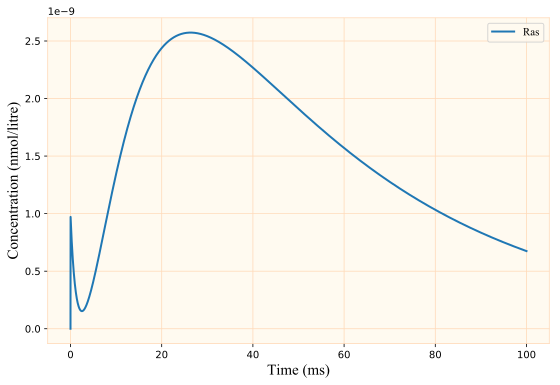

In [51]:
%config InlineBackend.figure_format = 'svg'
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.rc('axes',edgecolor='peachpuff')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)
plt.plot(t,x[:,24],  linewidth='2', label='Ras')

plt.legend(bbox_to_anchor=(1, 1), prop=font )
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (nmol/litre)', fontweight='bold',family='Times New Roman', fontsize=15)

plt.grid(color='peachpuff')

plt.savefig('Ras.svg')